<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget file.weasoft.com/images.zip
!wget file.weasoft.com/summary.csv

--2024-01-26 08:58:08--  http://file.weasoft.com/images.zip
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233782812 (223M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>] 222.95M  19.2MB/s    in 13s     

2024-01-26 08:58:21 (17.5 MB/s) - ‘images.zip’ saved [233782812/233782812]

--2024-01-26 08:58:21--  http://file.weasoft.com/summary.csv
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245681 (240K) [text/csv]
Saving to: ‘summary.csv’

summary.csv         100%[===================>] 239.92K   351KB/s    in 0.7s    

2024-01-26 08:58:22 (351 KB/s) - ‘summary.csv’ saved [245681/245681]



In [2]:
!unzip images.zip

Archive:  images.zip
  inflating: images/10952_050583472155929066.png  
  inflating: images/10952_06413864577904915.png  
  inflating: images/10952_0987733374849662.png  
  inflating: images/10952_10418284106334552.png  
  inflating: images/10952_16580034422892975.png  
  inflating: images/10952_23370361265754647.png  
  inflating: images/10952_2592774190030849.png  
  inflating: images/10952_46352491565819787.png  
  inflating: images/10952_5437104182840758.png  
  inflating: images/10952_7528510827860566.png  
  inflating: images/10952_8472447206478343.png  
  inflating: images/10952_9943772215519315.png  
  inflating: images/11182_009797678782551.png  
  inflating: images/11182_056521676103760465.png  
  inflating: images/11182_06305573566312661.png  
  inflating: images/11182_06673381672094503.png  
  inflating: images/11182_09202768527861127.png  
  inflating: images/11182_09932843308058081.png  
  inflating: images/11182_10408978036627115.png  
  inflating: images/11182_109830320

In [3]:
!wget file.weasoft.com/eff_s_3_19010.pt -O eff_s_1_8010.pt

--2024-01-26 08:58:27--  http://file.weasoft.com/eff_s_3_19010.pt
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161487054 (154M) [application/vnd.snesdev-page-table]
Saving to: ‘eff_s_1_8010.pt’

eff_s_1_8010.pt     100%[===================>] 154.01M  19.2MB/s    in 9.2s    

2024-01-26 08:58:36 (16.8 MB/s) - ‘eff_s_1_8010.pt’ saved [161487054/161487054]



In [4]:
!git clone https://github.com/suanfaxiaohuo/SwinOCSR.git
!pip install focal_loss_torch wandb
!pip3 install deepsmiles yacs tqdm

Cloning into 'SwinOCSR'...
remote: Enumerating objects: 453, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 453 (delta 104), reused 77 (delta 42), pack-reused 279
Receiving objects: 100% (453/453), 220.65 MiB | 13.32 MiB/s, done.
Resolving deltas: 100% (201/201), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [5]:
import sys
import os
import argparse
from tqdm import tqdm
import deepsmiles
from typing import Any, cast, Callable, List, Tuple, Union
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [6]:
import sys
sys.path.append("./SwinOCSR/model/Swin-transformer-focalloss")
sys.path.append("./SwinOCSR/model/")
from pre_transformer import Transformer
class FocalLossModelInference:
    """
    Inference Class
    """
    def __init__(self):
        # Load dictionary that maps tokens to integers
        word_map_path = './SwinOCSR/Data/500wan/500wan_shuffle_DeepSMILES_word_map'
        self.word_map = torch.load(word_map_path)
        self.inv_word_map = {v: k for k, v in self.word_map.items()}

        # Define device, load models and weights
        self.dev = "cuda" if torch.cuda.is_available() else "cpu"
        # self.args, config = self.get_inference_config()
        # self.encoder = build_model(config, tag=False)
        self.decoder = self.build_decoder()
        # self.load_checkpoint("./swin_transform_focalloss.pth")
        self.decoder = self.decoder.to(self.dev).eval()
        # self.encoder = self.encoder.to(self.dev).eval()

    def load_checkpoint(self, checkpoint_path):
        """
        Load checkpoint and update encoder and decoder accordingly

        Args:
            checkpoint_path (str): path of checkpoint file
        """
        print(f"=====> {checkpoint_path} <=====")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        # encoder_msg = self.encoder.load_state_dict(checkpoint['encoder'],
        #                                            strict=False)
        decoder_msg = self.decoder.load_state_dict(checkpoint['decoder'],
                                                   strict=False)
        # print(f"Encoder: {encoder_msg}")
        print(f"Decoder: {decoder_msg}")
        del checkpoint
        torch.cuda.empty_cache()

    def build_decoder(self):
        """
        This method builds the Transformer decoder and returns it
        """
        self.decoder_dim = 256  # dimension of decoder RNN
        self.ff_dim = 2048
        self.num_head = 8
        self.dropout = 0.1
        self.encoder_num_layer = 6
        self.decoder_num_layer = 6
        self.max_len = 277
        self.decoder_lr = 5e-4
        self.best_acc = 0.
        return Transformer(dim=self.decoder_dim,
                           ff_dim=self.ff_dim,
                           num_head=self.num_head,
                           encoder_num_layer=self.encoder_num_layer,
                           decoder_num_layer=self.decoder_num_layer,
                           vocab_size=len(self.word_map),
                           max_len=self.max_len,
                           drop_rate=self.dropout,
                           tag=False)
transformer_ = FocalLossModelInference()

In [7]:
# transformer_.build_decoder().cuda()(torch.rand(1,20).to(torch.int).cuda(),torch.rand(1,169,1536).cuda())

In [8]:
import base64
import pandas as pd
import os
# df = pd.read_csv("images_rows.csv")
# os.makedirs("images",exist_ok=1)
# def save_img(id):
#   row = df[df["id"]==id]
#   print(row["image"])
#   with open(f"images/{id}.png", "wb") as fh:
#       fh.write(base64.decodebytes(bytes(row["image"].item().replace("data:image/png;base64,",""), "utf-8")))
# df["id"].apply(save_img)

In [9]:
import sys
sys.path.append("./SwinOCSR/model/Swin-transformer-focalloss")
sys.path.append("./SwinOCSR/model/")

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [11]:
eff = torchvision.models.efficientnet_v2_s(weights='DEFAULT')
mynet = eff.features
class ImageEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.eff = mynet.to(device)
    self.projection = torch.nn.Linear(768,256).to(device)
  def forward(self, images):
    features = self.eff(images)
    features = torch.flatten(features, start_dim=2, end_dim=3)
    features = torch.permute(features, (0, 2, 1))
    return self.projection(features)
class Image2SMILES(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, image, text_in, xmask):
    image_feature = self.encoder(image)
    out = self.decoder(text_in, image_feature, x_mask=xmask)
    return out

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 116MB/s]


In [12]:
mod = torch.load("eff_s_1_8010.pt", map_location=device) #it is model not dict

In [13]:
def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch, maxlen

In [14]:
# gen = SMILESGenerator(mod.encoder, mod.decoder)
# res = gen.forward(torch.tensor(np.array(Image.open("./b.jpg").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32), [[77]], 100, 5)
# for str_ in res:
#   print(converter.decode("".join([reversed_word_map_[i] for i in str_])))


In [15]:
torch.topk(torch.tensor([1,2,3,4]),2)

torch.return_types.topk(
values=tensor([4, 3]),
indices=tensor([3, 2]))

In [16]:
# gen = SMILESGenerator(mod.encoder, mod.decoder)

NameError: name 'SMILESGenerator' is not defined

In [17]:
def triangle_mask(size):
    mask = 1- np.triu(np.ones((1, size, size)),k=1).astype('uint8')
    mask = torch.autograd.Variable(torch.from_numpy(mask))
    return mask

In [18]:
!wget file.weasoft.com/reverse.map

--2024-01-26 08:59:40--  http://file.weasoft.com/reverse.map
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 875
Saving to: ‘reverse.map’

reverse.map         100%[===================>]     875  --.-KB/s    in 0s      

2024-01-26 08:59:41 (121 MB/s) - ‘reverse.map’ saved [875/875]



In [19]:
reversed_word_map = {}
import json
with open("reverse.map","r") as f:
  reversed_word_map = json.loads(f.read())

In [20]:
from focal_loss.focal_loss import FocalLoss
m = torch.nn.Softmax(dim=-1)
lf = FocalLoss(gamma=2, ignore_index=0)#torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction="none")
def loss_fn(pred, truth):
  pred = m(pred)
  l = lf(pred, truth)
  return l

In [21]:
def mask_acc(pred, truth):
    pred = torch.argmax(pred, -1)
    mask = truth != 0
    match_case = truth == pred
    return torch.sum(mask*match_case)/torch.sum(mask)

In [22]:
BATCH_SIZE = 1

In [23]:
import pandas as pd
molecules_rows = pd.read_csv("summary.csv")

In [24]:
print("\n".join(list(set([i.split("_")[0] for i in os.listdir("images")]))))

11203
21159
11202
18175
91563
7977
71601
10952
175854
11241
11508
225936
8072
8100
6587
7966
78344
11240
12361
11250
13589
16565
11523
18302
6562
11536
439846
7745
13202
24250
7962
25975
18150
751
13855
8148
8902
2724488
7901
13556
11429
11182
8078
15274
22497934
14480
12417
286
68424
18632
7851
12250
19463
220010
638066
757
753


In [40]:
import random
converter = deepsmiles.Converter(rings=True, branches=True)
cids = list(molecules_rows["cid"])
train_cids = [i for i in cids if not i in [12361, 7962, 18632]]
# val_cids = ["a"]
val_cids = [i for i in cids if i in [12361, 7962, 18632]]
from PIL import ImageOps

def getitem(train=True):
  ti = []
  to = []
  imgs = []
  for i in range(18):
    prefix = random.choice(train_cids if train else val_cids)
    # if (train and name.startswith("638066"))or (not train and not name.startswith("638066")):
    # if train == name.startswith("638066"):
    #   continue
    name = random.choice([i for i in os.listdir("./images") if i.startswith(str(prefix)+"_")])
    # name = random.choice([i for i in os.listdir("./images")])

    img = Image.open(f"images/{name}").convert("RGB")
    if train:
      img = img.rotate(random.choice([0,90,180,270]), expand=0).resize((400,400))
      if random.random()>0.5:
        img = ImageOps.flip(img)
      if random.random()>0.5:
        img = ImageOps.mirror(img)
      img.crop((random.random()*40,random.random()*40,400-random.random()*40,400-random.random()*40))
    img = np.array(img.resize((400,400)), dtype="float32")
    if train:
      # img[:,:,0] *= random.random()*0.2+0.9
      img[:,:,1] *= random.random()*0.2+0.9
      img[:,:,2] *= random.random()*0.2+0.9
      img[:,:,:] *= random.random()*0.3+0.8
    img = torch.tensor(np.array(img)).permute(2, 0, 1).to(torch.float32).to(device)
    if train:
      # img+=torch.rand((3,400,400)).to(device)*50
      for _ in range(20):
        x,y = int(random.random()*380),int(random.random()*380)
        img[:,x:x+20, y:y+20] = torch.rand((3,20,20))*250

    # if train:
      # img*=torch.round(torch.tanh(5*torch.rand((3,400,400)))).to(device)
    # print(name)
    # print(converte//r.encode(molecules_rows[molecules_rows["cid"]==int(name.split("_")[0])]["canonicalsmiles"].item()))
    smiles = [transformer_.word_map[i] for i in converter.encode(molecules_rows[molecules_rows["cid"]==int(name.split("_")[0])]["canonicalsmiles"].item())]
    ti.append([77] + smiles)
    to.append(smiles + [78])
    imgs.append(img)
  return torch.stack(imgs), ti, to


In [26]:
torch.stack([torch.tensor([1,2]) for i in range(10)])

tensor([[1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2]])

In [ ]:
import pylab
batch = getitem(True)[0].cpu().permute(0, 2, 3, 1).numpy()
for i in batch:
  pylab.imshow(i/255)
  pylab.show()

In [28]:
# print("\n".join([str(i) for i in df["cid"].unique()]))

In [29]:
def val():
  running_loss = 0
  mod.train(False)
  # ids = os.listdir("images")[:10]

  valacc = []
  start_index = i
  image, text_in, text_out = getitem(train=False)

  image = image.to(device)
  text_out = pad_pack(text_out)[0].to(device)
  padded_x = pad_pack(text_in)

  xmask = triangle_mask(padded_x[1]).to(device)
  text_in = padded_x[0].to(device)

  outputs = mod(image, text_in, xmask)
  loss = loss_fn(outputs, text_out)



  running_loss += loss.item()
  valacc.append(mask_acc(outputs.detach(), text_out).item())
  mod.train(True)
  return running_loss, np.mean(valacc)


In [30]:
mod = torch.load("eff_s_1_8010.pt", map_location=device) #it is model not dict

In [31]:
for i in mod.decoder.parameters():
  i.require_grad = False

# for layers in mod.encoder.eff[:4]:
#   for i in layers.parameters():
#     i.require_grad = False

In [32]:
torch.manual_seed(0)

In [33]:
# 都改回来了还是一样好？ 没有，开始变差了，数据增强有用？还是冻结

In [41]:
def train(lr, T0, epoch, forzen, reload=False, split=4):
  global mod
  if reload:
    mod = torch.load("eff_s_1_8010.pt", map_location=device) #it is model not dict
    if forzen:
      for i in mod.decoder.parameters():
        i.require_grad = False
  losses = []
  access = []
  val_acc = []
  optimizer = torch.optim.AdamW(
    mod.parameters(),
    lr=lr)
  import pylab
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T0)
  running_loss = 0
  for epoch in range(epoch):
    mod.train(True)
    # ids = [i for i in os.listdir("images") if not i.startswith("638066")]
    # ids = os.listdir("images")[10:]
    # np.random.shuffle(ids)
    for i in range(len(os.listdir("images"))//(18*split)):#why set this and it be better or is it learning rate? it lower faster? hyper-parameter
      if i==None:
        continue
      start_index = i
      image, text_in, text_out = getitem(start_index)

      image = image.to(device) #mutli process cannot use cuda so moved here
      # image = torch.permute(image, (0, 3, 1, 2))
      text_out = pad_pack(text_out)[0].to(device)
      padded_x = pad_pack(text_in)

      xmask = triangle_mask(padded_x[1]).to(device)
      text_in = padded_x[0].to(device)

      optimizer.zero_grad()
      outputs = mod(image, text_in, xmask)
      #loss = loss_fn(outputs, text_outi) guaibude yyixiazinamegao
      loss = loss_fn(outputs, text_out)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()
      losses.append(loss.item())
      access.append(mask_acc(outputs.detach(), text_out))

    val_acc.append(val()[1])
    print(val_acc)
    scheduler.step()
    # print(optimizer.param_groups[0]["lr"])
  pylab.plot([i.item() for i in access], label="Train")
  pylab.plot(np.arange(len(val_acc))*(len(access)/len(val_acc)),val_acc,label="Val")
  pylab.legend()
  pylab.show()
  pylab.savefig(f"{lr}_{T0}_{epoch}.png")

In [35]:
# # hui yi test GED zhegejianju ye shi hui yi a
# for lr in [0.00001, 0.00002, 0.00004, 0.00008]:
#   for gamma in [0.95,0.9,0.8,0.7,0.6]:
#     train(lr, gamma, 6)

In [36]:
# #for and save aaa GED
# train(0.00003, 5, 20, False, reload=True)

[0.5406976938247681]
[0.5406976938247681, 0.47999998927116394]
[0.5406976938247681, 0.47999998927116394, 0.567415714263916]
[0.5406976938247681, 0.47999998927116394, 0.567415714263916, 0.48554912209510803]
[0.5406976938247681, 0.47999998927116394, 0.567415714263916, 0.48554912209510803, 0.609375]
[0.5406976938247681, 0.47999998927116394, 0.567415714263916, 0.48554912209510803, 0.609375, 0.699999988079071]
[0.5406976938247681, 0.47999998927116394, 0.567415714263916, 0.48554912209510803, 0.609375, 0.699999988079071, 0.6818181872367859]
[0.5406976938247681, 0.47999998927116394, 0.567415714263916, 0.48554912209510803, 0.609375, 0.699999988079071, 0.6818181872367859, 0.6377550959587097]
[0.5406976938247681, 0.47999998927116394, 0.567415714263916, 0.48554912209510803, 0.609375, 0.699999988079071, 0.6818181872367859, 0.6377550959587097, 0.7457627058029175]
[0.5406976938247681, 0.47999998927116394, 0.567415714263916, 0.48554912209510803, 0.609375, 0.699999988079071, 0.6818181872367859, 0.63775

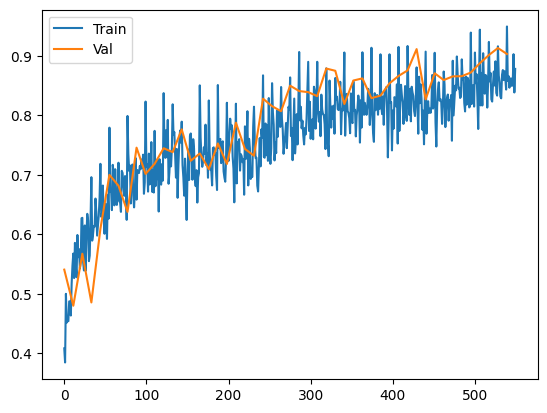

<Figure size 640x480 with 0 Axes>

In [42]:
train(0.00003, 20, 50, True, reload=True)

[0.42696627974510193]
[0.42696627974510193, 0.49504950642585754]
[0.42696627974510193, 0.49504950642585754, 0.5989847779273987]
[0.42696627974510193, 0.49504950642585754, 0.5989847779273987, 0.5197740197181702]
[0.42696627974510193, 0.49504950642585754, 0.5989847779273987, 0.5197740197181702, 0.621761679649353]
[0.42696627974510193, 0.49504950642585754, 0.5989847779273987, 0.5197740197181702, 0.621761679649353, 0.6377550959587097]
[0.42696627974510193, 0.49504950642585754, 0.5989847779273987, 0.5197740197181702, 0.621761679649353, 0.6377550959587097, 0.6526315808296204]
[0.42696627974510193, 0.49504950642585754, 0.5989847779273987, 0.5197740197181702, 0.621761679649353, 0.6377550959587097, 0.6526315808296204, 0.6368715167045593]
[0.42696627974510193, 0.49504950642585754, 0.5989847779273987, 0.5197740197181702, 0.621761679649353, 0.6377550959587097, 0.6526315808296204, 0.6368715167045593, 0.6890243887901306]
[0.42696627974510193, 0.49504950642585754, 0.5989847779273987, 0.51977401971817

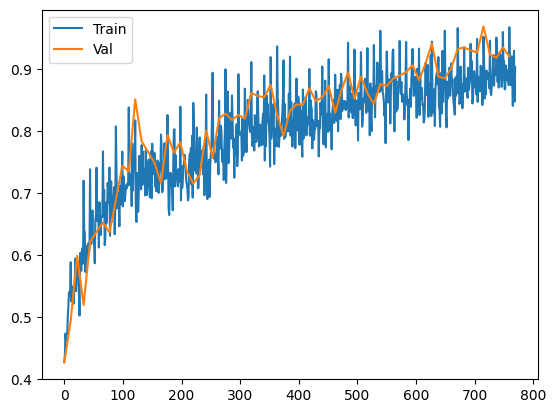

<Figure size 640x480 with 0 Axes>

In [50]:
train(0.00003, 20, 70, True, reload=True)

In [38]:
def mutli_image(imgs):
  pass

In [39]:
train(0.00003, 20, 50, True, reload=True)

[0.42168673872947693]
[0.42168673872947693, 0.5]


KeyboardInterrupt: 

In [ ]:
#leng haishi buneng tiaojieliangduhe jiazaoying haiyou kuai unengtaida lengduzikunlenghlkun

In [ ]:
#ffalengduzisuankouke yiweibuxingle mian houmian zhijieshangqule

In [ ]:
train(0.00003, 20, 30, True, reload=True)

In [ ]:
#no blocking
train(0.00003, 20, 30, True, reload=True)


In [ ]:
train(0.00003, 20, 40, True, reload=True)

In [ ]:
#mol iso weight
train(0.00003, 20, 30, True, reload=True)

In [ ]:
#image iso weight
train(0.00003, 20, 30, True, reload=True)

In [ ]:
#image iso weight without random blocks
train(0.00003, 20, 30, True, reload=True)

In [ ]:
train(0.00003, 10, 20, True, reload=True, split=2)

In [ ]:
train(0.00002, 0.7, 5)


In [ ]:
train(0.00002, 0.7, 5)



In [43]:
class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, image, text_in_, max_len, beam): #just changed beam=1 and it runs so beam cannot be random number???  yeah it has to been factor of 676, which is 2 2 13 13 but original paper did not use beam search
    image_feature = self.encoder(image)
    top_n = list([list(i) for i in torch.tensor(text_in_).repeat(beam,1).detach().cpu().numpy()])
    top_n_p = [1]*beam
    # print(top_n)
    image_feature = image_feature.repeat_interleave(beam, dim=0)#.repeat_interleave(beam)
    for i in range(max_len):
      if beam == 1:
        padded_text, l = pad_pack(top_n)
        padded_text = padded_text.to(device)
        out = self.decoder(padded_text, image_feature, x_mask=triangle_mask(l).to(device))
        out = out[0,-1,:]
        next = torch.argmax(out)
        top_n[0] += [next.detach().cpu().item()]
        if next == 78:
          return top_n
        continue
      padded_text, l = pad_pack(top_n)
      padded_text = padded_text.to(device)
      out = self.decoder(padded_text, image_feature, x_mask=triangle_mask(l).to(device))
      out = out[:,-1,:]
      next = torch.topk(torch.flatten(out), beam)
      indices2d = np.array(np.unravel_index(next.indices.cpu().numpy(), out.shape)).T
      print(next.indices)
      new_top_n = []
      count = 0
      for j in indices2d:
        beam_number = j[0]
        char = j[1]
        # top_n_p[beam_number]*=next.values[]
        if char == 78:
          count += 1
          new_top_n.append(top_n[beam_number])
        else:
          new_top_n.append(top_n[beam_number] + [char])
      if count == beam:
        return new_top_n
      top_n = new_top_n
    return top_n
gen = SMILESGenerator(mod.encoder, mod.decoder)


In [45]:
reversed_word_map_={}
for i in reversed_word_map.keys():
  reversed_word_map_[int(i)] = reversed_word_map[i]

In [ ]:
!ls images/12361*

In [49]:
res = gen.forward(torch.tensor(np.array(Image.open("d.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32), [[77]], 100, 1)
for str_ in res:
  print(converter.decode("".join([reversed_word_map_[i] for i in str_])))


<start>CCOCCCO<end>


In [ ]:
Image.open("d.jpg")

In [ ]:
Image.open("images/a.jpg")

In [ ]:
#for and save aaa GED
train(0.00004, 0.95, 30, 6)


In [ ]:
image, text_in, text_out = getitem(train=False)

image = image.to(device)
text_out = pad_pack(text_out)[0].to(device)
padded_x = pad_pack(text_in)

xmask = triangle_mask(padded_x[1]).to(device)
text_in = padded_x[0].to(device)

outputs = mod(image, text_in, xmask)
converter.decode("".join([reversed_word_map[str(np.argmax(i))] for i in outputs[4].detach().cpu().numpy()]))

In [ ]:
# 12361!! finallly works bieren kajnw o

In [ ]:
text_in

In [ ]:
pylab.imshow(image[5].permute(1,2,0).cpu()/255)

In [ ]:
pylab.imshow(image[3].permute(1,2,0).cpu()/255)


In [ ]:
train(0.00004, 0.7, 6)
# No black out

In [ ]:
#This time very well how???????
torch.seed()

In [ ]:
res = np.array([i.item() for i in access[350:]])

In [ ]:
np.sum(res==1)/len(res)

In [ ]:
pylab.plot([i.item() for i in access], label="Train")
pylab.plot(np.arange(len(val_acc))*(len(access)/len(val_acc)),val_acc,label="Val")
pylab.legend()

In [ ]:
image.requires_grad_()
outputs = mod(image, text_in, xmask)
loss = loss_fn(outputs, text_out)
loss.backward()

In [ ]:
img = image[0].permute(1,2,0).detach().cpu()
pylab.imshow(img/torch.max(img))

In [ ]:
ans = image.grad[0].permute(1,2,0).cpu()
ans = (ans-torch.mean(ans))/torch.std(ans)
pylab.imshow(torch.sum(((ans)), dim=-1), cmap="gray")

In [ ]:
mod.decoder.layer[0].attn2